# Simple RNN model - raw sequences

In [1]:
# Preprocessing and encoding variables
import pandas as pd
import numpy as np

# Using Skicit-learn to split data into training and testing sets
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# For characterlevel one hot encoding or label encoding 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Activation
import tensorflow.keras.utils as utils
from keras import optimizers

# For RNN architecture
from tensorflow.keras.layers import SimpleRNN

# For plotting
import matplotlib.pyplot as plt

# Use scikit-learn to grid search the batch size and epochs
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

### Uploading genomes

In [2]:
G = pd.read_csv('../input/genomes/G1_translated.csv').iloc[:, 1:]

In [3]:
G = G.dropna()

In [4]:
G.tail(10)

,Type,Sequence,Translated
8639,CDS,GTGAAAGATTTATTAAAGTTTCTGAAAGCGCAGACTAAAACCGAAG...,VKDLLKFLKAQTKTEEFDAIKIALASPDMIRSWSFGEVKKPETINY...
8640,CDS,ATGAGCGGAAAACCGGCGGCGCGTCAGGGTGACATGACGCAGTATG...,MSGKPAARQGDMTQYGGSIVQGSAGVRIGAPTGVACSVCPGGVTSG...
8641,CDS,ATGAGCGGAAAACCAGCGGCGCGTCAGGGAGATATGACTCAGTATG...,MSGKPAARQGDMTQYGGPIVQGSAGVRIGAPTGVACSVCPGGMTSG...
8642,CDS,ATGATTGAACGCGGTAAATTTCGCTCACTGACGCTGATTAACTGGA...,MIERGKFRSLTLINWNGFFARTFDLDELVTTLSGGNGAGKSTTMAA...
8643,CDS,ATGTTGTACGATAAATCCCTTGAGAGGGATAACTGTGGTTTCGGCC...,MLYDKSLERDNCGFGLIAHIEGEPSHKVVRTAIHALARMQHRGAIL...
8644,CDS,ATGAATAAGAAATTTAAATATAAGAAATCGCTTTTAGCGGCTATTT...,MNKKFKYKKSLLAAILSATLLAGCDGGGSGSSSDTPPVDSGTGSLP...
8645,CDS,ATGAACAGGACCAGTCCCTATTATTGTCGCCGCTCAGTACTTTCCT...,MNRTSPYYCRRSVLSLLISALIYAPPGMAAFTTNVIGVVNDETVDG...
8646,CDS,ATGGCAGATAATCCAGACCCTTCATCGCTCCTGCCGGACGTGTTTT...,MADNPDPSSLLPDVFSPATRDWFLRAFKQPTAVQPQTWHVAARSEH...
8647,CDS,ATGAAAAAGTTACGCGTAGCCGCCTGCATGCTAATGCTGGCGCTGG...,MKKLRVAACMLMLALAGCDNNDNAPTAVKKDAPSEVTKAASSENAS...
8648,CDS,ATGGCTACGAAGAAGAGAAGTGGAGAAGAAATAAATGACCGACAAA...,MATKKRSGEEINDRQILCGMGIKLRRLTAGICLITQLAFPMAAAAQ...


In [5]:
print('The shape of our dataframe is:', G.shape)
print('Rows:', G.shape[0])
print('Columns:', G.shape[1])

The shape of our dataframe is: (8649, 3)
Rows: 8649
Columns: 3


### Encoding data

Using sklearn OneHotEncoder and LabelEncoder

#### Labels

In [6]:
def encode_feature(array):
    """ Encode a categorical array into a number array
    
    :param array: array to be encoded
    :return: numerical array
    """
  
    encoder = preprocessing.LabelEncoder()
    encoder.fit(array)
    return encoder.transform(array)

In [7]:
class_names = ['CDS', 'LORF']
labels = G["Type"].values
print(labels)

['CDS' 'CDS' 'CDS' ... 'CDS' 'CDS' 'CDS']


In [8]:
labels = encode_feature(labels)
labels

array([0, 0, 0, ..., 0, 0, 0])

#### Sequences

The sequenes are are tokenized using keras tokenizer, then padded and finally one hot encoded.

In [9]:
# Extract sequences
samples = G['Sequence'].values
samples = list(samples)
samples[0:5]

['AAAGGCTAA',
 'AAAAAAGAGTGA',
 'ATGAAAAATAGTGTCGCTGAGCACTAA',
 'ATGATTAAATCCGACCAGGAGACCTGA',
 'ATGCTTCATTGCAAAGGGAATAATCTATGA']

In [10]:
# Tokenizer configured to only take into account the top-4 most common words
tokenizer = Tokenizer(char_level=True)

# This builds the word index
tokenizer.fit_on_texts(samples)

# This turns strings into lists of integer indices.
seq_of_int = tokenizer.texts_to_sequences(samples)

In [11]:
seq_of_int[0]

[4, 4, 4, 1, 1, 2, 3, 4, 4]

In [12]:
print('Longest sequence is:', len(samples[len(G)-1]))

Longest sequence is: 7077


In [13]:
#max_len = len(samples[len(G)-1])
max_len = 4000
seq_padded = sequence.pad_sequences(seq_of_int, maxlen=max_len, dtype='int32', value=0.0) # if maxlen=None then the maximum lenght is the longest sequence in genome

In [14]:
np.shape(seq_padded)

(8649, 4000)

#### OneHotEncode padded integer sequences

The reason why we can not simply convert every character to its position in the alphabet, e.g. a — 1, b — 2 etc.) is that this would lead the network to assume that the characters are on an ordinal scale, instead of a categorical - the letter Z not is “worth more” than an A.

In [15]:
seq_one_hot = utils.to_categorical(seq_padded)

In [16]:
np.shape(seq_one_hot)

(8649, 4000, 5)

### Create training and test data

In [17]:
# Split the data into training and testing sets -> x = features and y = labels/targets
train_x, test_x, train_y, test_y = train_test_split(seq_padded, labels, test_size = 0.2, random_state = 42)

In [18]:
print('Input data:')
print(len(train_x), 'train sequences')
print(len(test_x), 'test sequences')

Input data:
6919 train sequences
1730 test sequences


In [19]:
np.shape(train_x)

(6919, 4000)

### LSTM model

#### Choosing number of nodes and layers
There is no final, definite, rule of thumb on how many nodes (or hidden neurons) or how many layers one should choose, and very often a trial and error approach will give you the best results for your individual problem. Generally, 2 layers have shown to be enough to detect more complex features. More layers can be better but also harder to train. As a general rule of thumb — 1 hidden layer work with simple problems, like this, and two are enough to find reasonably complex features.

#### Choosing additional hyperparameters

- **Dropout**: Every LSTM layer should be accompanied by a Dropout layer. This layer will help to prevent overfitting by ignoring randomly selected neurons during training, and hence reduces the sensitivity to the specific weights of individual neurons. 20% is often used as a good compromise between retaining model accuracy and preventing overfitting.
- **Activation layer**: Technically, this can be included into the density layer, but there is a reason to split this apart. While not relevant here, splitting the density layer and the activation layer makes it possible to retrieve the reduced output of the density layer of the model. Which activation function to use is, again, depending on the application. Sigmoid function is used for binary classification problems. 
- **Loss function**: Loss function and activation function are often chosen together. Cross-entropy or more precise the binary cross-entropy, is the preferred loss function since we are faced with a binary classification problem. 
- **Optimizer**: For choosing the optimizer, adaptive moment estimation, short _Adam_, has been shown to work well in most practical applications and works well with only little changes in the hyperparameters. 
- **Metric**: In many cases, judging the models’ performance from an overall _accuracy_ point of view will be the option easiest to interpret as well as sufficient in resulting model performance.


#### Simple LSTM with embedding layer:

https://mmuratarat.github.io/2019-06-12/embeddings-with-numeric-variables-Keras

There are three parameters to the embedding layer:
- **input_dim** : Size of the vocabulary
- **output_dim** : Embedding size. Output length of the vector for each word
- **input_length** : Maximum length of a sequence

In [20]:
input_dim = 5 # input dimension: 4 bases + padding 

embedding_size = min(np.ceil((input_dim)/2), 50)
embedding_size = int(embedding_size)

output_dim = embedding_size
input_length = max_len

In [21]:
model = Sequential()
model.add(Embedding(input_dim, output_dim)) # parameter input_length not required, because no flattening needed (using RNN layer now, not Dense layer)
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_x, train_y,
                    epochs=500,
                    batch_size=128,
                    validation_split=0.2)

2022-05-07 10:21:20.062169: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-07 10:21:20.172961: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-07 10:21:20.173715: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-07 10:21:20.174887: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/500


2022-05-07 10:21:25.239522: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


44/44 [==============================] - 16s 287ms/step - loss: 0.6966 - acc: 0.5424 - val_loss: 0.6903 - val_acc: 0.4884
Epoch 2/500
44/44 [==============================] - 12s 279ms/step - loss: 0.6861 - acc: 0.5380 - val_loss: 0.6828 - val_acc: 0.5455
Epoch 3/500
44/44 [==============================] - 12s 276ms/step - loss: 0.6852 - acc: 0.6126 - val_loss: 0.6568 - val_acc: 0.6163
Epoch 4/500
44/44 [==============================] - 12s 280ms/step - loss: 0.6552 - acc: 0.6343 - val_loss: 0.6740 - val_acc: 0.5506
Epoch 5/500
44/44 [==============================] - 12s 280ms/step - loss: 0.6540 - acc: 0.6226 - val_loss: 0.5932 - val_acc: 0.7030
Epoch 6/500
44/44 [==============================] - 12s 279ms/step - loss: 0.6373 - acc: 0.6482 - val_loss: 0.5824 - val_acc: 0.7355
Epoch 7/500
44/44 [==============================] - 12s 279ms/step - loss: 0.6251 - acc: 0.6690 - val_loss: 0.5650 - val_acc: 0.7645
Epoch 8/500
44/44 [==============================] - 12s 279ms/step - loss

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 3)           15        
_________________________________________________________________
lstm (LSTM)                  (None, 128)               67584     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 67,728
Trainable params: 67,728
Non-trainable params: 0
_________________________________________________________________


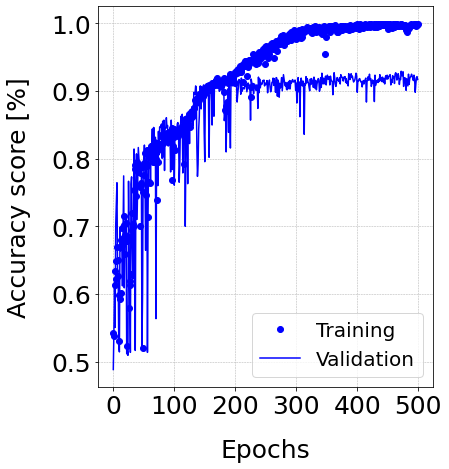

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.subplots(figsize=(6,7))

plt.plot(epochs, acc, 'bo', label='Training')
plt.plot(epochs, val_acc, 'b', label='Validation')
plt.xlabel('Epochs', fontsize=25, labelpad=20)
plt.ylabel('Accuracy score [%]',fontsize=25, labelpad=20)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.grid(linestyle = '--', linewidth = 0.5)
plt.legend(loc=4, fontsize=20)

plt.savefig('max_len_nuc.png', dpi=300, bbox_inches='tight')
plt.show()

In [24]:
scores = model.evaluate(test_x, test_y, verbose=0)
print('Test accuracy:', scores[1])

Test accuracy: 0.9219653010368347
